# Solving the Titanic Classification Problem Using the Stacking Method

I am personally enjoying following data science competitions on Kaggle. I am currently completing the Machine Learning Engineer Nanodegree by Udacity which provides me with a fantastic mathematical and practical introduction to the most important machine learning algorithms. I found it interesting how lecturers in the Nanodegree emphasise applying a single best algorithm for a given problem to find an accurate solution. In contrast, professionals in data science competitions use Stacking to build complex models with many different underlying machine learning algorithms. Through Stacking, accuracy is maximised in practice.

In this notebook I will not attempt to replicate one of those highly complex solutions. Instead, I will solve the Titanic classification problem found on Kaggle by first using various machine learning algorithms by themselves and later using a simple Stacking model. Finally, I will verify whether a Stacking solution gives a highest accuracy over single algorithms. 

The description, data set, and evaluation criteria for the problem can be found at https://www.kaggle.com/c/titanic.

For this project I am using Python 3 and its most popular libraries for Data Science including pandas and numpy. I am using seaborn and matplotlib for data visualisation and scikit-learn and xgboost for machine learning.


In [2]:
# suppress depreciation warnings 
import warnings
warnings.filterwarnings('ignore')

# Load in our libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, \
AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV #for tuning hyperparameters 
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 

# Feature/Data exploration

On the Kaggle website there is the following description of the data:

### Overview

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include **gender_submission.csv**, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Data Dictionary

**Variable	(Definition)**

survival	(Survival	0 = No, 1 = Yes) <br>
pclass	(Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd)<br>
sex	(Sex)<br>	
Age	(Age in years)	<br>
sibsp	(# of siblings / spouses aboard the Titanic)<br>
parch	(# of parents / children aboard the Titanic)	<br>
ticket	(Ticket number)	<br>
fare	(Passenger fare)	<br>
cabin	(Cabin number)	<br>
embarked	(Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton)

### Variable Notes

**pclass:** A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [3]:
# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

PassengerId = test['PassengerId']

I will display both datasets to get a better understanding of them and confirm that the PassengerID is the only feature which train has and test does not have. 

In [4]:
display(train.head())
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### NaN values

First, I want to figure out which features have any NaN values. Most algorithms can not handle NaN values, so I will take care of them before doing any statistical prediction.

In [5]:
total = set()

for i, y in enumerate(pd.isnull(train).sum() > 0):
    if y:
        total.add(train.columns[i])
        
for i, y in enumerate(pd.isnull(test).sum() > 0):
    if y:
        total.add(test.columns[i])

print(total)

{'Embarked', 'Age', 'Fare', 'Cabin'}


The features that have some NaN values are: 
* Age
* Cabin 
* Embarked
* Fare

## Cleaning and Pre-processesing the Data

In this notebook my main goal is to varify whether Stacking increases the outcome of predictive modelling. Therefore, I have taken some data pre-processing ideas from other published kernels on Kaggle. Additionally, I have included my own ideas where I found an adjustment to be appropriate. 

Embarked does not take any numeric values, so I will check whether any of the values is most common in this feature.

In [6]:
# figure out which value to fill in for the NaN values in Embarked
c = {}
for i in train['Embarked']:
    if i in c:
        c[i] += 1
    else:
        c[i] = 1
print(c)
for i in test['Embarked']:
    if i in c:
        c[i] += 1
    else:
        c[i] = 1
print(c)

{'S': 644, 'C': 168, 'Q': 77, nan: 2}
{'S': 914, 'C': 270, 'Q': 123, nan: 2}


I figured out that 'S' (Southampton) is by far the most common port of embarkation and I will therefore fill all the NaN values with 'S'. 

In [7]:
# I will apply the data cleaning to both datasets for consistency.
full = [train, test]

# I found this online in another published solution. It is a good way  
# to create a feature with the Title of a person:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full:
    # Create a new feature Title:
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                                 'Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 
                                                 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].fillna(0)

    
    #turn Name into a numerical value
    dataset['Name_length'] = dataset['Name'].apply(len)
    
    #get rid of NaN values in Cabin and define which cabin class 
    # the passenger is travelling in
    dataset['Has_cabin'] = \
    dataset['Cabin'].apply(lambda x: 
                           "cabin_0" if type(x) == float 
                           else "cabin_" + x[0])
    
    #create feature indicating family size travelling with
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 
    
    #create feature indicating if travelling alone
    dataset['IsAlone'] = 0 
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    #fill in 'S' for NaN values in Embarked
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = \
    dataset['Embarked'].apply(lambda x: "embarked_" + x)
    
    #fill NaN in Fare by using the median values
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
    # fill NaN in Age by using the median values
    dataset['Age'] = dataset['Age'].fillna(train['Fare'].median())
    
    #mapping Sex to create a numeric value
    dataset['Sex'] = \
    dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    
    

# creating numerical dummy variables from Has_cabin, Title, and Embarked
cabin_add = pd.get_dummies(train['Has_cabin'])
title_add = pd.get_dummies(train['Title'])
embarked_add = pd.get_dummies(train['Embarked'])
train = pd.concat([train, cabin_add, title_add, embarked_add], axis=1)

cabin_add = pd.get_dummies(test['Has_cabin'])
title_add = pd.get_dummies(test['Title'])
embarked_add = pd.get_dummies(test['Embarked'])
test = pd.concat([test, cabin_add, title_add, embarked_add], axis=1)

# drop the redundant elements 
drop_elements = ['PassengerId', 'Name', 'Ticket', 
                 'Cabin', 'SibSp', 'Embarked', 'Has_cabin', 'Title']
train = train.drop(drop_elements, axis=1)
test = test.drop(drop_elements, axis=1)

## finally, check the new output: 
print('Dataset train:')
display(train.columns)
display(train.head())

print('Dataset test:')
display(test.columns)
display(test.head())

Dataset train:


Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Name_length',
       'FamilySize', 'IsAlone', 'cabin_0', 'cabin_A', 'cabin_B', 'cabin_C',
       'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T', 'Master', 'Miss',
       'Mr', 'Mrs', 'Rare', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

,Survived,Pclass,Sex,Age,Parch,Fare,Name_length,FamilySize,IsAlone,cabin_0,...,cabin_G,cabin_T,Master,Miss,Mr,Mrs,Rare,embarked_C,embarked_Q,embarked_S
0,0,3,1,22.0,0,7.2500,23,2,0,1,...,0,0,0,0,1,0,0,0,0,1
1,1,1,0,38.0,0,71.2833,51,2,0,0,...,0,0,0,0,0,1,0,1,0,0
2,1,3,0,26.0,0,7.9250,22,1,1,1,...,0,0,0,1,0,0,0,0,0,1
3,1,1,0,35.0,0,53.1000,44,2,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,3,1,35.0,0,8.0500,24,1,1,1,...,0,0,0,0,1,0,0,0,0,1


Dataset test:


Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Name_length', 'FamilySize',
       'IsAlone', 'cabin_0', 'cabin_A', 'cabin_B', 'cabin_C', 'cabin_D',
       'cabin_E', 'cabin_F', 'cabin_G', 'Master', 'Miss', 'Mr', 'Mrs', 'Rare',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

,Pclass,Sex,Age,Parch,Fare,Name_length,FamilySize,IsAlone,cabin_0,cabin_A,...,cabin_F,cabin_G,Master,Miss,Mr,Mrs,Rare,embarked_C,embarked_Q,embarked_S
0,3,1,34.5,0,7.8292,16,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0
1,3,0,47.0,0,7.0000,32,2,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,2,1,62.0,0,9.6875,25,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0
3,3,1,27.0,0,8.6625,16,1,1,1,0,...,0,0,0,0,1,0,0,0,0,1
4,3,0,22.0,1,12.2875,44,3,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In my new datasets I have no NaN values and all the values are numeric. Also, I have transformed all categorical values into dummy variables. Now I can apply the algorithms well. 

I have noticed though, that the cabin_T dummy was not added in the test dataset (because there was no "1" value for cabin_T in the test dataset). Some algorithms require an equal column length for testing and training and therefore I will add the cabin_T feature with only 0 values to the test dataset. 

In [8]:
# test has no cabin_T column. Adding cabin_T column: 
test['cabin_T'] = np.array(np.zeros(test.shape[0]), dtype=np.int)
cols = test.columns.tolist()
cols = cols[:16] + cols[-1:] + cols[16:24]
test = test[cols]

# Visualisation

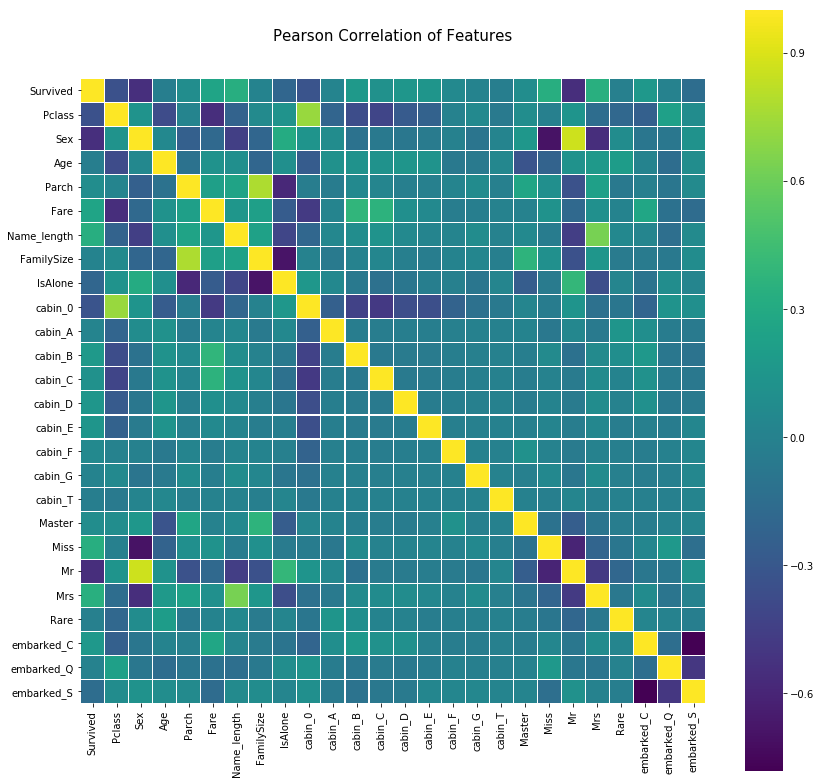

In [9]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white')

Because of all the dummy variables, this heatmap might seem slightly messy. I can still get a feeling for the importance of certain features. For example, I can see that Sex as well as Mr have a strong negative correlation with Survived, so men had a lower chance of surviving. The relative light green colour in Name_length shows that passengers with longer names had a better chance of surviving. 

These are some interesting insights. Now, let us dive into training the models that will hopefully produce some accurate classifications for our test set.

# First Level Classification Algorithms

Now that the datasets are adjusted, I will start training seven different machine learning algorithms. I have tried to include algorithms with different underlying principles to ensure diverse results, so I have as much variety as possible when I will be Stacking them. 

For the individual algorithms I will use a grid search 3-fold cross validation to find the best hyperparameters from a small choice of parameters. Then, I will train the algorithm with the fine tuned hyperparameters and save the results for later use. The scoring method is specified by the competition and will be a simple accuracy score (correctly classified data points over all data points). 

Please note that, due to the nature of Kaggle competitions, the actual score for the testing set can only be seen when submitting the correct .csv file. If you want to verify my results by submitting the scores yourself, please feel free to resubmit my work on Kaggle yourself. I am happy to send over my .ipynb file upon request. 

In [10]:
SEED = 0 # for reproducibility if I want to re-run the script

#creating the target feature for our training test set 
survived = train['Survived'] 
del train['Survived']

X_train = train
y_train = survived
X_test = test

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 891 samples.
Testing set has 418 samples.


### Gradient Boosting Classifier

In [11]:
gbc = GradientBoostingClassifier(random_state=SEED)

parameters = {'max_depth': [2, 5, 10], 
              'min_samples_split': [2, 100], 
              'n_estimators': [100, 500]}

scorer = make_scorer(accuracy_score)

# we will use the default grid search crossvalidation with 3 folds. 
grid_obj = GridSearchCV(estimator=gbc,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

gbc_params = grid_fit.best_params_
gbc_score = grid_fit.best_score_
gbc_params # display the best parameters for gbc 

{'max_depth': 10, 'min_samples_split': 100, 'n_estimators': 100}

In [12]:
gbc = GradientBoostingClassifier(max_depth=10,
                                min_samples_split=100,
                                n_estimators=100,
                                random_state=SEED)


gbc.fit(X_train, y_train)

gbc_pred = gbc.predict(X_test)

gbc_features = gbc.feature_importances_

### Decision Tree Classifier

In [13]:
dtc = DecisionTreeClassifier(random_state=SEED)

parameters = {'splitter': ['best', 'random'], 
              'max_depth': [2, 5, 10, 15], 
              'min_samples_split': [2, 5, 10],
             'max_features': [1.0, 0.75, 0.5, 0.25]}

scorer = make_scorer(accuracy_score)


grid_obj = GridSearchCV(estimator=dtc,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

dtc_params = grid_fit.best_params_
dtc_score = grid_fit.best_score_
dtc_params 

{'max_depth': 15,
 'max_features': 1.0,
 'min_samples_split': 10,
 'splitter': 'random'}

In [14]:
dtc = DecisionTreeClassifier(max_depth=15,
                                max_features=1.0,
                                min_samples_split=10,
                                splitter='random',
                                random_state=SEED)

dtc.fit(X_train, y_train)
dtc_pred = gbc.predict(X_test)

dtc_features = dtc.feature_importances_

### Ada Boost Classifier

In [15]:
abc = AdaBoostClassifier(random_state=SEED)

parameters = {'n_estimators': [50, 100, 200], 
              'learning_rate': [0.7, 1, 1.5]}

scorer = make_scorer(accuracy_score)


grid_obj = GridSearchCV(estimator=abc,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

abc_params = grid_fit.best_params_
abc_score = grid_fit.best_score_
abc_params 

{'learning_rate': 0.7, 'n_estimators': 50}

In [16]:
abc = AdaBoostClassifier(learning_rate=0.7,
                                n_estimators=50,
                                random_state=SEED)

abc.fit(X_train, y_train)

abc_pred = gbc.predict(X_test)

abc_features = abc.feature_importances_

### Extra Trees Classifier

In [17]:
etc = ExtraTreesClassifier(random_state=SEED)

parameters = {'n_estimators': [10, 50, 100], 
              'max_features': [1.0, 0.75, 0.5],
             'max_depth': [3, 6, 9, 12],
             'min_samples_split': [2, 5, 15]}

scorer = make_scorer(accuracy_score)


grid_obj = GridSearchCV(estimator=etc,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

etc_params = grid_fit.best_params_
etc_score = grid_fit.best_score_
etc_params 

{'max_depth': 6,
 'max_features': 0.75,
 'min_samples_split': 5,
 'n_estimators': 10}

In [18]:
etc = ExtraTreesClassifier(max_depth=6,
                                max_features=0.75,
                                min_samples_split=5,
                                n_estimators=10,
                                random_state=SEED)

etc.fit(X_train, y_train)

etc_pred = gbc.predict(X_test)

etc_features = etc.feature_importances_

### Support Vector Machine Classifier

In [19]:
svm = SVC(random_state=SEED)

parameters = {'C': [1, 10, 100], 
              'kernel': ['rbf', 'linear'],
             'gamma': [0.1, 0.01, 0.001]}

scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(estimator=svm,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

svm_params = grid_fit.best_params_
svm_params 

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

In [20]:
svm = SVC(C=1,
            gamma=0.1,
            kernel='linear',
            random_state=SEED)

svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

In [21]:
svm_score = grid_fit.best_score_

### K Nearest Neighbors

In [22]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors': [2, 5, 10, 20], 
              'weights': ['uniform', 'distance']}

scorer = make_scorer(accuracy_score)

# uses 3-fold as default (explain??) 
grid_obj = GridSearchCV(estimator=knn,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

knn_params = grid_fit.best_params_
knn_score = grid_fit.best_score_
knn_params # display the best parameters for knn 


{'n_neighbors': 10, 'weights': 'uniform'}

In [23]:
knn = KNeighborsClassifier(n_neighbors=10,
                                weights='uniform')

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)


### XGB 

Extreme Gradient Boosting classifier. An algorithm that is often used in winning solutions at Kaggle competitions.

In [24]:
gbm = xgb.XGBClassifier()
parameters = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'min_child_weight': [1,10, 20],
             'max_depth': [1, 3, 6, 10]}

scorer = make_scorer(accuracy_score)


grid_obj = GridSearchCV(estimator=gbm,
                       param_grid=parameters,
                       scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

gbm_params = grid_fit.best_params_
gbm_score = grid_fit.best_score_
gbm_params

{'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 10}

In [25]:
gbm = xgb.XGBClassifier(learning_rate=0.2,
                                min_child_weight=10,
                       max_depth=6)

gbm.fit(X_train, y_train)

gbm_pred = gbm.predict(X_test)

# Second-Level Predictions from the First-level Output

Now that I have trained the individual algorithms I will create a voting method of a simple average as well as a weighted average to prove whether Stacking those algorithms will lead to a higher accuracy score than without Stacking. The weighted average assigns higher weights on the outcome of those algorithms that performed a higher score during the cross validation process. If the average score is 0.5 or above the final output will be 1, else 0. 

In [26]:
x_train = np.column_stack((gbc.predict(X_train), dtc.predict(X_train), 
                          abc.predict(X_train), etc.predict(X_train),
                          svm.predict(X_train), knn.predict(X_train),
                          gbm.predict(X_train)))
x_test = np.column_stack((gbc_pred, dtc_pred, abc_pred, etc_pred,
                          svm_pred, knn_pred, gbm_pred))

In [27]:
def simple_average(x):
    '''creates a simple average vote'''
    output = []
    for i in x:
        if (sum(i)/7) >= 0.5:
            output.append(1)
        else:
            output.append(0)

    return output

def weighted_average(x):
    '''creates a weighted average vote'''
    output = []
    
    weights = [gbc_score, dtc_score, abc_score, 
             etc_score, svm_score, knn_score, gbm_score]
    for i in x:
        s = 0
        for weight, y in enumerate(i):
            s += weights[weight] * y
        
        if (s/sum(weights)) >= 0.5:
            output.append(1)
        else:
            output.append(0)

    return output

In [28]:
#creating a 2D np array with all the individual 
# outputs from all algorithms for each individual data point
# on the test data set. 
x_test_actual = np.column_stack((gbc.predict(test), dtc.predict(test), 
                          abc.predict(test), etc.predict(test),
                          svm.predict(test), knn.predict(test), 
                          gbm.predict(test)))

In [29]:
#creating the output with a simple and a weighted average
sim_output = simple_average(x_test_actual)
weigh_output = weighted_average(x_test_actual)

In the following lines of code I am creating .csv files for submissions. Then I will note down manually the Kaggle accuracy score for each individual submission to check which algorithm has achieved the highest accuracy. 

In [30]:
#simple average
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId, 
                                   'Survived': sim_output})
StackingSubmission.to_csv('StackingSubmission_0.csv', index=False)

In [31]:
#weighted average
StackingSubmission0 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': weigh_output})
StackingSubmission0.to_csv('StackingSubmission_1.csv', index=False)

In [32]:
# Extra Tree Classifier only
output = etc.predict(test)
output
StackingSubmission2 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission2.to_csv('StackingSubmission_2.csv', index=False)

In [33]:
# Gradient Boosting Classifier only
output = gbc.predict(test)
output
StackingSubmission3 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission3.to_csv('StackingSubmission_3.csv', index=False)

In [34]:
# Decision Tree Classifier only
output = dtc.predict(test)
output
StackingSubmission5 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission5.to_csv('StackingSubmission_4.csv', index=False)

In [35]:
# Ada Boost Classifier only
output = abc.predict(test)
output
StackingSubmission6 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission6.to_csv('StackingSubmission_5.csv', index=False)

In [36]:
# Support Vector Machine Classifier only
output = svm.predict(test)
output
StackingSubmission7 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission7.to_csv('StackingSubmission_6.csv', index=False)

In [37]:
# K-NearestNeighbor Classifier only
output = knn.predict(test)
output
StackingSubmission8 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission8.to_csv('StackingSubmission_7.csv', index=False)

In [38]:
# XGB Classifier only
output = gbm.predict(test)
output
StackingSubmission9 = pd.DataFrame({ 'PassengerId': PassengerId, 
                                    'Survived': output})
StackingSubmission9.to_csv('StackingSubmission_8.csv', index=False)

# Final Accuracy Scores: 

| method | score  |
|---|---|
|  Extra Tree Classifier |  0.77033 |
| Gradient Boosting Classifier  | 0.75598  |
|  Decision Tree Classifier | 0.71770  |
| Ada Boost Classifier  |  0.77033 |
| Support Vector Machine Classifier  | 0.77033  |
|  K-Nearest Neighbor | 0.68421  |
|  XGB Classifier | 0.76076  |
| **simple average on 2nd level** | **0.77511**   |
| **weighted average on 2nd level** | **0.77511**  |

My thesis is confirmed and I have achieved the highest score with the output of the stacked model. In this case the weighted average yields the same accuracy score as the simple average. I can also see that the Extra Tree Classifier, Ada Boost Classifier and Support Vector Machine Classifier all achieve the second highest score. 

The improvement in scores of 0.5 % points is not very high. However, I do see this project to be successful as in this example the outcome was what I have expected. I know that data scientists in Kaggle competitions have significantly more complex Stacking methods also including more than two levels of predictions with more than 7 base models. 

I am satisfied with my results and I am motivated to do further research to experiment with more complex Stacking methods to achieve the highest accuracy scores possible.